In [76]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from concurrent.futures import ThreadPoolExecutor ,ProcessPoolExecutor,as_completed
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)


In [77]:
cwd = os.getcwd()
# Construct the full path to the 'FPL' directory
fpl_path = os.path.join(cwd, '..', '..', 'FPL')
# Add it to the system path
sys.path.append(fpl_path)
from fpl_api_collection import (
    get_bootstrap_data,
    get_current_gw,
    get_fixt_dfs,
    get_fixture_data,
    get_player_id_dict,
    get_current_season,
    get_player_data,
)

In [78]:
# Retrieve and prepare player data
ele_types_data = get_bootstrap_data()['element_types']
ele_types_X_weighted = pd.DataFrame(ele_types_data)
ele_data = get_bootstrap_data()['elements']
ele_df = pd.DataFrame(ele_data)
ele_df['element_type'] = ele_df['element_type'].map(ele_types_X_weighted.set_index('id')['singular_name_short'])
ele_copy = ele_df.copy()

# Retrieve and prepare team data
teams_data = get_bootstrap_data()['teams']
teams_df = pd.DataFrame(teams_data)

# Map team IDs to names for fixture processing
team_name_mapping = pd.Series(teams_df.name.values, index=teams_df.id).to_dict()
ele_copy['team_name'] = ele_copy['team'].map(teams_df.set_index('id')['short_name'])
ele_copy['full_name'] = ele_copy['first_name'].str.cat(ele_copy['second_name'].str.cat(ele_copy['team_name'].apply(lambda x: f" ({x})"), sep=''), sep=' ')

# Retrieve player dictionary and current season/gameweek
full_player_dict = get_player_id_dict('total_points', web_name=False)
crnt_season = get_current_season()
ct_gw = get_current_gw()

# Retrieve and process fixture data
fixture_data = get_fixture_data()
fixtures_df = pd.DataFrame(fixture_data)
fixtures_df.drop(columns='stats', inplace=True)

fixtures_df['team_h'] = fixtures_df['team_h'].replace(team_name_mapping)
fixtures_df['team_a'] = fixtures_df['team_a'].replace(team_name_mapping)
fixtures_df = fixtures_df.drop(columns=['pulse_id'])

# Format fixture dates
timezone = 'Europe/London'
fixtures_df['datetime'] = pd.to_datetime(fixtures_df['kickoff_time'], utc=True)
fixtures_df['local_time'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%A %d %B %Y %H:%M')
fixtures_df['local_date'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%d %A %B %Y')
fixtures_df['local_hour'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%H:%M')

# Retrieve fixture difficulty rating data
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()
full_player_dict = get_player_id_dict('total_points', web_name=False)

In [79]:
def convert_score_to_result(df):
    df.loc[df['was_home'] == True, 'result'] = df['team_h_score'] \
        .astype('Int64').astype(str) \
        + '-' + df['team_a_score'].astype('Int64').astype(str)
    df.loc[df['was_home'] == False, 'result'] = df['team_a_score'] \
        .astype('Int64').astype(str) \
        + '-' + df['team_h_score'].astype('Int64').astype(str)
        
def convert_opponent_string(df):
    df.loc[df['was_home'] == True, 'vs'] = df['vs'] + ' (A)'
    df.loc[df['was_home'] == False, 'vs'] = df['vs'] + ' (H)'
    df.loc[df['was_home'] == True, 'Team_player'] = df['Team_player'] + ' (H)'
    df.loc[df['was_home'] == False, 'Team_player'] = df['Team_player'] + ' (A)'
    return df

def collate_hist_df_from_name(player_name):
    p_id = [k for k, v in full_player_dict.items() if v == player_name]
    position = ele_copy.loc[ele_copy['full_name'] == player_name, 'element_type'].iloc[0]
    Team = ele_copy.loc[ele_copy['full_name'] == player_name, 'team_name'].iloc[0]
    p_data = get_player_data(str(p_id[0]))
    p_df = pd.DataFrame(p_data['history'])
    convert_score_to_result(p_df)
    p_df.loc[p_df['result'] == '<NA>-<NA>', 'result'] = '-'
    rn_dict = {'round': 'GW','kickoff_time':'kickoff_time', 'opponent_team': 'vs', 'total_points': 'Pts',
               'minutes': 'Mins', 'goals_scored': 'GS', 'assists': 'A',
               'clean_sheets': 'CS', 'goals_conceded': 'GC', 'own_goals': 'OG',
               'penalties_saved': 'Pen_Save', 'penalties_missed': 'Pen_Miss',
               'yellow_cards': 'YC', 'red_cards': 'RC', 'saves': 'S',
               'bonus': 'B', 'bps': 'BPS', 'influence': 'I', 'creativity': 'C',
               'threat': 'T', 'ict_index': 'ICT', 'value': 'Price',
               'selected': 'SB', 'transfers_in': 'Tran_In',
               'transfers_out': 'Tran_Out', 'expected_goals': 'xG',
               'expected_assists': 'xA', 'expected_goal_involvements': 'xGI',
               'expected_goals_conceded': 'xGC', 'result': 'Result'}
    p_df.rename(columns=rn_dict, inplace=True)
    col_order = ['GW','kickoff_time', 'vs', 'Result', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA',
                 'xGI', 'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S',
                 'YC', 'RC', 'B', 'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB',
                 'Tran_In', 'Tran_Out', 'was_home']
    p_df = p_df[col_order]
    # map opponent teams
    
    p_df['Price'] = p_df['Price']/10
    p_df['vs'] = p_df['vs'].map(teams_df.set_index('id')['short_name'])
    p_df['Pos'] = position
    p_df['Team_player'] = Team
    #convert_opponent_string(p_df)
    #p_df.drop('was_home', axis=1, inplace=True)
    #p_df.set_index('GW', inplace=True)
    p_df.sort_values('GW', ascending=False, inplace=True)
    return p_df

In [80]:
def collate_all_players_parallel(full_player_dict, max_workers=None):
    # Determine optimal max_workers if not provided
    if max_workers is None:
        max_workers = os.cpu_count() * 2  # Suitable for I/O-bound tasks like web scraping

    # Define a helper function to retrieve data for a single player
    def get_player_data(player_name):
        try:  # Add exception handling inside the worker function
            player_df = collate_hist_df_from_name(player_name)
            player_df['Player'] = player_name  # Add player name column
            return player_df
        except Exception as e:
            print(f"Error processing {player_name}: {e}")
            return pd.DataFrame() # Return empty DataFrame on error


    # Use ThreadPoolExecutor with a with statement for proper resource management
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks and store futures in a dictionary for easier error handling
        futures = {executor.submit(get_player_data, player_name): player_name 
                   for player_name in full_player_dict.values()}

        results = []
        for future in as_completed(futures):
            player_name = futures[future]
            try:
                result_df = future.result()  # Get the result or raise an exception
                results.append(result_df)
            except Exception as e:
                print(f"Error retrieving result for {player_name}: {e}")

    # Concatenate all successful results into a single DataFrame outside the loop
    all_players_df = pd.concat(results, axis=0, ignore_index=True)  # ignore_index for cleaner index
    return all_players_df

In [81]:
all_players_data = collate_all_players_parallel(full_player_dict)

In [82]:
merged_home = pd.merge(all_players_data, teams_df[['short_name',
                                                    'strength_overall_home', 
                                                    'strength_overall_away', 
                                                    'strength_attack_home', 
                                                    'strength_attack_away', 
                                                    'strength_defence_home', 
                                                    'strength_defence_away']],
                       left_on='Team_player', 
                       right_on='short_name', 
                       how='left')

# Merge for the opponent team
merged_opponent = pd.merge(merged_home, 
                            teams_df[['short_name',
                                       'strength_overall_home', 
                                       'strength_overall_away', 
                                       'strength_attack_home', 
                                       'strength_attack_away', 
                                       'strength_defence_home', 
                                       'strength_defence_away']],
                            left_on='vs', 
                            right_on='short_name', 
                            how='left', 
                            suffixes=('', '_opponent'))

# Optionally drop the 'short_name' columns for opponents if you don't need them
merged_opponent = merged_opponent.drop(columns=['short_name', 'short_name_opponent'])
merged_opponent=convert_opponent_string(merged_opponent)


In [83]:
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()

ct_gw = get_current_gw()

new_fixt_df = team_fixt_df.loc[:, ct_gw:(ct_gw+2)]
new_fixt_cols = ['GW' + str(col) for col in new_fixt_df.columns.tolist()]
new_fixt_df.columns = new_fixt_cols

new_fdr_df = team_fdr_df.loc[:, ct_gw:(ct_gw+2)]

def get_home_away_str_dict():
    new_fdr_df.columns = new_fixt_cols
    result_dict = {}
    for col in new_fdr_df.columns:
        values = list(new_fdr_df[col])
        max_length = new_fixt_df[col].str.len().max()
        if max_length > 7:
            new_fixt_df.loc[new_fixt_df[col].str.len() <= 7, col] = new_fixt_df[col].str.pad(width=max_length+9, side='both', fillchar=' ')
        strings = list(new_fixt_df[col])
        value_dict = {}
        for value, string in zip(values, strings):
            if value not in value_dict:
                value_dict[value] = []
            value_dict[value].append(string)
        result_dict[col] = value_dict
    
    merged_dict = {}
    for k, dict1 in result_dict.items():
        for key, value in dict1.items():
            if key in merged_dict:
                merged_dict[key].extend(value)
            else:
                merged_dict[key] = value
    for k, v in merged_dict.items():
        decoupled_list = list(set(v))
        merged_dict[k] = decoupled_list
    for i in range(1,6):
        if i not in merged_dict:
            merged_dict[i] = []
    return merged_dict
	
	

In [84]:
sui=get_home_away_str_dict()

In [85]:
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()

ct_gw = get_current_gw()

new_fixt_df = team_fixt_df.loc[:, ct_gw:(ct_gw+2)]
new_fixt_cols = ['GW' + str(col) for col in new_fixt_df.columns.tolist()]
new_fixt_df.columns = new_fixt_cols

def create_team_fdr_dataframe():
    # Create a list to store the results
    team_fdr_list = []
    for col in new_fdr_df.columns:
        # Get the values from the FDR DataFrame
        fdr_values = new_fdr_df[col].values
        # Get the corresponding teams from the fixture DataFrame
        teams = new_fixt_df[col].values
        # Combine teams with their FDR values into the list
        for team, fdr in zip(teams, fdr_values):
            # Ensure that we don't include empty FDR values or teams
            if pd.notna(fdr) and fdr > 0:  # Adjust condition as needed
                team_fdr_list.append({'team': team.strip(), 'fdr': fdr})
    # Create a DataFrame from the list
    team_fdr_df = pd.DataFrame(team_fdr_list)
    return team_fdr_df

# Example usage
team_fdr_df = create_team_fdr_dataframe()


In [86]:
team_fdr_map = dict(zip(team_fdr_df['team'], team_fdr_df['fdr']))
# Map the 'fdr' values to the 'merged_opponent' dataframe based on the 'Team_player' column
merged_opponent['Team_fdr'] = merged_opponent['Team_player'].map(team_fdr_map)
merged_opponent['opponent_fdr'] = merged_opponent['vs'].map(team_fdr_map)

In [87]:
columns_to_convert = ['GW', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 
                      'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 
                      'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 
                      'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 
                      'strength_defence_home', 'strength_defence_away', 'strength_overall_home_opponent', 
                      'strength_overall_away_opponent', 'strength_attack_home_opponent', 'strength_attack_away_opponent', 
                      'strength_defence_home_opponent', 'strength_defence_away_opponent', 'Team_fdr', 'opponent_fdr']


# Convert specified columns to float
for col in columns_to_convert:
    merged_opponent[col] = pd.to_numeric(merged_opponent[col], errors='coerce')  # Convert to float and set errors to NaN if conversion fails


In [88]:
merged_opponent['season']=2425
next_fixture_gw = fixtures_df[fixtures_df['event']==ct_gw]

####FIXTURE

In [89]:
# Merge for team_a
new_fix_gw_a = pd.merge(
    next_fixture_gw,
    teams_df[['short_name', 'name']],  # Include 'name' for matching
    left_on='team_a',  # Match with team_a
    right_on='name', 
    how='left'
)

# Rename the short_name column for clarity
new_fix_gw_a.rename(columns={'short_name': 'team_a_short_name'}, inplace=True)

# Merge for team_h
new_fix_gw = pd.merge(
    new_fix_gw_a,
    teams_df[['short_name', 'name']],  # Include 'name' for matching
    left_on='team_h',  # Match with team_h
    right_on='name', 
    how='left'
)

# Rename the short_name column for clarity
new_fix_gw.rename(columns={'short_name': 'team_h_short_name'}, inplace=True)
new_fix_gw = new_fix_gw.drop(columns=['name_x', 'name_y'], errors='ignore')
new_fix_gw['team_h_short_name'] = new_fix_gw['team_h_short_name'] + ' (H)'
new_fix_gw['team_a_short_name'] = new_fix_gw['team_a_short_name'] + ' (A)'


In [90]:
teams_next_gw = pd.concat([new_fix_gw['team_a_short_name'], new_fix_gw['team_h_short_name']]).unique()
filtered_players = merged_opponent

filtered_players[['team_player_score', 'vs_score']] = filtered_players['Result'].str.split('-', expand=True)

# Convert the scores to integers (optional, depending on how you want to use them)
filtered_players['team_player_score'] = filtered_players['team_player_score'].astype(int)
filtered_players['vs_score'] = filtered_players['vs_score'].astype(int)
filtered_players.drop(columns=['Result'], axis=1, inplace=True)

In [91]:
new_fix_gw_test = new_fix_gw[['event', 'team_h_short_name', 'team_a_short_name','kickoff_time']].rename(
    columns={
        'event': 'GW',
        'team_h_short_name': 'Team_home',
        'team_a_short_name': 'Team_away',
    }
)

###model

In [92]:
history_path= os.path.join(cwd, '..', '..', 'data', 'history', 'clean_player_2324.csv')

player_history = pd.read_csv(history_path, index_col=0)
# Concatenating the dataframes vertically
concatenated_df = pd.concat([filtered_players, player_history], ignore_index=True)

# If you want to reset the index after concatenation
concatenated_df.reset_index(drop=True, inplace=True)


new_fix_gw_test['season']=2425

In [93]:
# 1. Calculate the average statistics for each team from df_player
df_player=concatenated_df
df_fixture=new_fix_gw_test

last_gw = df_player[df_player['season'] == 2425]['GW'].max()
filtered_players_fixture = df_player[
    (df_player['season'] == 2425) ]
filtered_pl = df_player[
    (df_player['season'] == 2425) & (df_player['GW'] == last_gw)
]
fit=filtered_pl[['Team_player', 'Player', 'Pos', 'Price']]

fit['team'] = fit['Team_player'].str.extract(r'([A-Za-z]+) \(')[0]


# Pre-extract team names for both 'Team_home' and 'Team_away' once
df_fixture['home_team'] = df_fixture['Team_home'].str.extract(r'([A-Za-z]+)')[0]
df_fixture['away_team'] = df_fixture['Team_away'].str.extract(r'([A-Za-z]+)')[0]

# Create dictionaries for home and away team mappings for 'GW', 'kickoff_time', and 'season'
home_team_mapping = df_fixture.set_index('home_team')[['GW', 'kickoff_time', 'season','Team_home']].to_dict(orient='index')
away_team_mapping = df_fixture.set_index('away_team')[['GW', 'kickoff_time', 'season','Team_away']].to_dict(orient='index')

# Combine home and away team mappings
combined_mapping = {}
for team, data in home_team_mapping.items():
    combined_mapping[team] = data
for team, data in away_team_mapping.items():
    if team in combined_mapping:
        # Merge the home and away data (if applicable)
        combined_mapping[team].update(data)
    else:
        combined_mapping[team] = data

# Now map the values to the 'fit' DataFrame for 'GW', 'kickoff_time', and 'season'
fit['GW'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('GW'))
fit['kickoff_time'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('kickoff_time'))
fit['season'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('season'))
fit['Team_player'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('Team_home') or 
                                combined_mapping.get(team, {}).get('Team_away'))



####################################################################

# Create dictionaries for home-to-away and away-to-home teams to find opponents
home_to_away = df_fixture.set_index('home_team')['Team_away'].to_dict()
away_to_home = df_fixture.set_index('away_team')['Team_home'].to_dict()

# Combine home and away opponent mappings into a single dictionary
combined_opponent_mapping = {}
combined_opponent_mapping.update(home_to_away)
combined_opponent_mapping.update(away_to_home)

# Map the 'vs' column in the 'fit' DataFrame to their corresponding opponent
fit['vs'] = fit['team'].map(combined_opponent_mapping)


In [94]:
pulga=filtered_players_fixture
columns_to_normalize = [
    'Mins','Pts', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC', 
    'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 'I', 
    'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out'
]

In [95]:
total_stats = pulga.groupby('Player')[columns_to_normalize].mean().reset_index()

In [96]:
df_pred = pd.merge(fit, total_stats,
                           left_on='Player', right_on='Player', how='left')

In [97]:
df_pred['vs_temp'] = df_pred['vs'].str.replace(r'\s?\(.*\)', '', regex=True)
df_pred['Team_player_temp'] = df_pred['Team_player'].str.replace(r'\s?\(.*\)', '', regex=True)

# Create mappings for each strength based on the team names
strength_overall_home_map = teams_df.set_index('short_name')['strength_overall_home'].to_dict()
strength_overall_away_map = teams_df.set_index('short_name')['strength_overall_away'].to_dict()
strength_attack_home_map = teams_df.set_index('short_name')['strength_attack_home'].to_dict()
strength_attack_away_map = teams_df.set_index('short_name')['strength_attack_away'].to_dict()
strength_defence_home_map = teams_df.set_index('short_name')['strength_defence_home'].to_dict()
strength_defence_away_map = teams_df.set_index('short_name')['strength_defence_away'].to_dict()

# Map the strengths for the team in `Team_player_temp`
df_pred['strength_overall_home'] = df_pred['Team_player_temp'].map(strength_overall_home_map)
df_pred['strength_overall_away'] = df_pred['Team_player_temp'].map(strength_overall_away_map)
df_pred['strength_attack_home'] = df_pred['Team_player_temp'].map(strength_attack_home_map)
df_pred['strength_attack_away'] = df_pred['Team_player_temp'].map(strength_attack_away_map)
df_pred['strength_defence_home'] = df_pred['Team_player_temp'].map(strength_defence_home_map)
df_pred['strength_defence_away'] = df_pred['Team_player_temp'].map(strength_defence_away_map)

# Map the strengths for the opponent team in `vs_temp`
df_pred['strength_overall_home_opponent'] = df_pred['vs_temp'].map(strength_overall_home_map)
df_pred['strength_overall_away_opponent'] = df_pred['vs_temp'].map(strength_overall_away_map)
df_pred['strength_attack_home_opponent'] = df_pred['vs_temp'].map(strength_attack_home_map)
df_pred['strength_attack_away_opponent'] = df_pred['vs_temp'].map(strength_attack_away_map)
df_pred['strength_defence_home_opponent'] = df_pred['vs_temp'].map(strength_defence_home_map)
df_pred['strength_defence_away_opponent'] = df_pred['vs_temp'].map(strength_defence_away_map)

# Optionally drop the 'short_name' columns for opponents if you don't need them
df_next_fixt = df_pred.drop(columns=['vs_temp','Team_player_temp'])

df_next_fixt['Team_fdr'] = df_next_fixt['Team_player'].map(team_fdr_map)
df_next_fixt['opponent_fdr'] = df_next_fixt['vs'].map(team_fdr_map)
df_next_fixt['was_home'] = df_next_fixt['Team_player'].apply(lambda x: True if '(H)' in x else False)

In [98]:
df_next_fixt_gw=df_next_fixt

In [99]:
# List of columns to convert to float
columns_to_convert = [
    'GW', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC',
    'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 'Price', 'I', 'C',
    'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 'strength_overall_home',
    'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
    'strength_defence_home', 'strength_defence_away',
    'strength_overall_home_opponent', 'strength_overall_away_opponent',
    'strength_attack_home_opponent', 'strength_attack_away_opponent',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    'Team_fdr', 'opponent_fdr'
]

df_next_fixt_gw[columns_to_convert] = df_next_fixt_gw[columns_to_convert].astype(float)
df_player[columns_to_convert] = df_player[columns_to_convert].astype(float)


In [100]:
# Make a copy of X to apply weights
X_weighted = df_player.copy()

In [101]:
import os
import joblib
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the objective function for Optuna
def objective_optuna(trial):
    # Define the hyperparameter space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.15, 0.25),
        'max_depth': trial.suggest_int('max_depth', 2,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 0.1, 3),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'gamma': trial.suggest_float('gamma', 0.01, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1),
    }

    model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor',**params)

    # Use K-fold cross-validation to better estimate performance
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean()  # Take the negative because cross_val_score returns negative MSE

    return mean_mse

# Function to perform hyperparameter tuning using Optuna
def auto_tune_hyperparameters(X, y, n_trials=5):
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check if previous Optuna study exists
    study_path = "optuna_study.joblib"
    if os.path.exists(study_path):
        study = joblib.load(study_path)
        print("Loaded existing Optuna study for incremental tuning.")
    else:
        study = optuna.create_study(direction='minimize')
        print("Starting a new Optuna study for hyperparameter tuning.")

    # Run optimization
    study.optimize(objective_optuna, n_trials=n_trials)

    # Save the study for future reference or incremental tuning
    joblib.dump(study, study_path)
    print("Optuna study saved.")

    # Retrieve the best parameters
    best_params = study.best_params
    return best_params

# Function to train, evaluate, and save the model if it improves performance
def train_and_save_model(X, y, model_path="xgb_model.joblib", score_path="best_score.joblib"):
    # Check if a model and score already exist
    if os.path.exists(model_path) and os.path.exists(score_path):
        model = joblib.load(model_path)
        best_score = joblib.load(score_path)
        print(f"Loaded existing model with best score: {best_score:.4f}")
    else:
        best_score = float("inf")  # Initialize to infinity for first-time training

    # Tune hyperparameters if no previous params are found
    best_params = auto_tune_hyperparameters(X, y)
    new_model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor', **best_params)
    print("Starting new model training with tuned hyperparameters.")

    # Train the model with early stopping
    new_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

    # Evaluate the new model on the test set
    y_pred = new_model.predict(X_test)
    new_score = mean_squared_error(y_test, y_pred)

    # Compare and save the best model based on the score
    if new_score < best_score:
        print(f"New model improves from {best_score:.4f} to {new_score:.4f}. Saving new model.")
        joblib.dump(new_model, model_path)
        joblib.dump(new_score, score_path)
        print("New model and score saved.")
        return new_model
    else:
        print(f"New model score {new_score:.4f} did not improve. Retaining the existing model.")
        return model


In [ ]:

X_weighted['kickoff_time'] = pd.to_datetime(X_weighted['kickoff_time'])

# 1. Position Weights
position_weights = {
    'GKP': 0.9,
    'DEF': 1.1,
    'MID': 1.3,
    'FWD': 1.5
}

# Apply weight based on position
X_weighted['position_weight'] = X_weighted['Pos'].map(position_weights)

# 2. Home/Away Game Weights
home_weight = 1.2  # Home game weight
away_weight = 1.0  # Away game weight

# Apply home/away weight
X_weighted['home_away_weight'] = X_weighted['was_home'].map({True: home_weight, False: away_weight})

# 3. Kickoff Time Weights
def assign_time_weight(kickoff_time):
    if 6 <= kickoff_time.hour < 12:
        return 0.95  # Morning games tend to have lower energy
    elif 12 <= kickoff_time.hour < 18:
        return 1.0   # Standard midday games
    elif 18 <= kickoff_time.hour < 24:
        return 1.1   # Evening games often see more action
    else:
        return 1.05  # Late-night games may see more relaxed performances

X_weighted['time_weight'] = X_weighted['kickoff_time'].apply(assign_time_weight)

# 4. Team and Opponent Strength Weights
X_weighted['team_strength_weight'] = (X_weighted['strength_overall_home'] + X_weighted['strength_attack_home'] - X_weighted['strength_defence_home']) * 1.1
X_weighted['opponent_strength_weight'] = (X_weighted['strength_overall_away_opponent'] + X_weighted['strength_attack_away_opponent'] - X_weighted['strength_defence_away_opponent'])

# Strength ratio, adjust for home/away dynamics
X_weighted['strength_weight'] = X_weighted['team_strength_weight'] / X_weighted['opponent_strength_weight']

# 5. Transfer Activity Weights
X_weighted['transfer_weight'] = X_weighted['Tran_In'] / (X_weighted['Tran_In'] + X_weighted['Tran_Out'] + 1)

# 6. Disciplinary Risk Weights
X_weighted['penalty_risk_weight'] = 1 - (X_weighted['Pen_Miss'] * 0.3 + X_weighted['YC'] * 0.1 + X_weighted['RC'] * 0.2)

# 7. Fixture Difficulty Rating (FDR) Weights
X_weighted['opponent_difficulty_weight'] = 1 / (X_weighted['opponent_fdr'] + 1)


# 9. Minutes Played Weight
X_weighted['minutes_weight'] = X_weighted['Mins'] / 90  # Normalize to a full game

# 10. Expected Goals (xG) and Expected Assists (xA) Weights
X_weighted['xg_weight'] = X_weighted['xG'] * 1.2  # Weight xG higher as it's a strong predictor of goals
X_weighted['xa_weight'] = X_weighted['xA'] * 1.1  # xA is also valuable for midfielders and forwards

# 11. Final Weight Calculation
X_weighted['final_weight'] = (
    X_weighted['position_weight'] * 
    X_weighted['home_away_weight'] * 
    X_weighted['time_weight'] * 
    X_weighted['strength_weight'] * 
    X_weighted['transfer_weight'] * 
    X_weighted['penalty_risk_weight'] * 
    X_weighted['opponent_difficulty_weight'] *
    X_weighted['minutes_weight'] * 
    X_weighted['xg_weight'] * 
    X_weighted['xa_weight']
)

"\nX_weighted['kickoff_time'] = pd.to_datetime(X_weighted['kickoff_time'])\n\n# 1. Position Weights\nposition_weights = {\n    'GKP': 0.9,\n    'DEF': 1.1,\n    'MID': 1.3,\n    'FWD': 1.5\n}\n\n# Apply weight based on position\nX_weighted['position_weight'] = X_weighted['Pos'].map(position_weights)\n\n# 2. Home/Away Game Weights\nhome_weight = 1.2  # Home game weight\naway_weight = 1.0  # Away game weight\n\n# Apply home/away weight\nX_weighted['home_away_weight'] = X_weighted['was_home'].map({True: home_weight, False: away_weight})\n\n# 3. Kickoff Time Weights\ndef assign_time_weight(kickoff_time):\n    if 6 <= kickoff_time.hour < 12:\n        return 0.95  # Morning games tend to have lower energy\n    elif 12 <= kickoff_time.hour < 18:\n        return 1.0   # Standard midday games\n    elif 18 <= kickoff_time.hour < 24:\n        return 1.1   # Evening games often see more action\n    else:\n        return 1.05  # Late-night games may see more relaxed performances\n\nX_weighted['time

In [ ]:
features = ['GW', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 
            'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 'was_home', 'strength_overall_home', 'strength_overall_away', 
            'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'strength_overall_home_opponent', 
            'strength_overall_away_opponent', 'strength_attack_home_opponent', 'strength_attack_away_opponent', 'strength_defence_home_opponent', 
            'strength_defence_away_opponent', 'Team_fdr', 'opponent_fdr', 'season', 'position_weight', 'home_away_weight', 'time_weight', 
            'strength_weight', 'final_weight', 'transfer_weight', 'opponent_difficulty_weight', 'penalty_risk_weight']
X = X_weighted[features]
y = X_weighted['Pts']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
best_model = train_and_save_model(X_train, y_train)
best_model

Loaded existing Optuna study for incremental tuning.


[I 2024-11-15 11:17:15,834] Trial 10 finished with value: 0.08448801783081931 and parameters: {'n_estimators': 470, 'learning_rate': 0.24337776352273716, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7393315736730868, 'colsample_bytree': 0.8661731224049811, 'gamma': 0.27485439273779266, 'reg_alpha': 0.42245299995736363, 'reg_lambda': 0.997050496756724}. Best is trial 2 with value: 0.03463193289632244.
[I 2024-11-15 11:17:22,272] Trial 11 finished with value: 0.09261961448716946 and parameters: {'n_estimators': 120, 'learning_rate': 0.17516874158128865, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6086514815097, 'colsample_bytree': 0.8473002047054099, 'gamma': 0.49593970097558226, 'reg_alpha': 0.25689531791760667, 'reg_lambda': 0.3367700846867481}. Best is trial 2 with value: 0.03463193289632244.
[I 2024-11-15 11:17:30,296] Trial 12 finished with value: 0.09042284383029094 and parameters: {'n_estimators': 180, 'learning_rate': 0.24919083910214715, 'max_depth': 4, 'min_c

Optuna study saved.
Starting new model training with tuned hyperparameters.
[0]	validation_0-rmse:1.92027
[1]	validation_0-rmse:1.52824
[2]	validation_0-rmse:1.22708
[3]	validation_0-rmse:1.01429
[4]	validation_0-rmse:0.86463
[5]	validation_0-rmse:0.73853
[6]	validation_0-rmse:0.65015
[7]	validation_0-rmse:0.58383
[8]	validation_0-rmse:0.53449
[9]	validation_0-rmse:0.50374
[10]	validation_0-rmse:0.48100
[11]	validation_0-rmse:0.45967
[12]	validation_0-rmse:0.44585
[13]	validation_0-rmse:0.42710
[14]	validation_0-rmse:0.41969
[15]	validation_0-rmse:0.40430
[16]	validation_0-rmse:0.39965
[17]	validation_0-rmse:0.39370
[18]	validation_0-rmse:0.38527
[19]	validation_0-rmse:0.37926
[20]	validation_0-rmse:0.37420
[21]	validation_0-rmse:0.36987
[22]	validation_0-rmse:0.36805
[23]	validation_0-rmse:0.36458
[24]	validation_0-rmse:0.35958
[25]	validation_0-rmse:0.35676
[26]	validation_0-rmse:0.35430
[27]	validation_0-rmse:0.35267
[28]	validation_0-rmse:0.35247
[29]	validation_0-rmse:0.34899
[30]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.643679057448135, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.4397333147243308,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2475312530832605,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=290, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

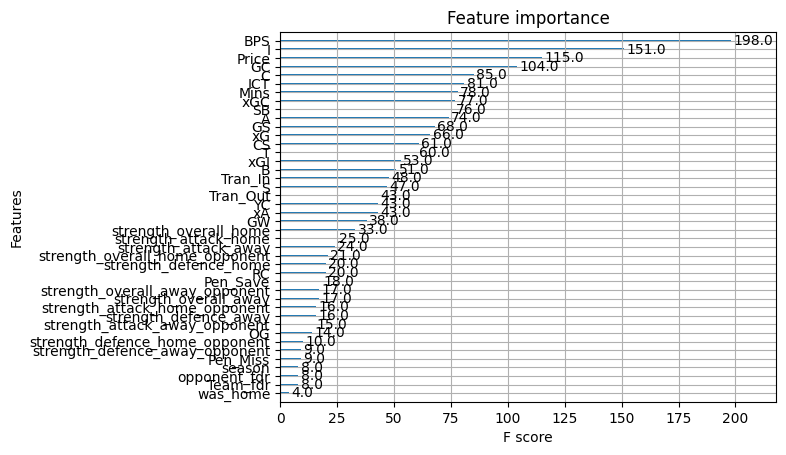

In [106]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model)
plt.show()

In [107]:
ssuiio=df_next_fixt_gw

In [ ]:

ssuiio['kickoff_time'] = pd.to_datetime(ssuiio['kickoff_time'])

# 1. Position Weights
position_weights = {
    'GKP': 0.9,
    'DEF': 1.1,
    'MID': 1.3,
    'FWD': 1.5
}

# Apply weight based on position
ssuiio['position_weight'] = ssuiio['Pos'].map(position_weights)

# 2. Home/Away Game Weights
home_weight = 1.2  # Home game weight
away_weight = 1.0  # Away game weight

# Apply home/away weight
ssuiio['home_away_weight'] = ssuiio['was_home'].map({True: home_weight, False: away_weight})

# 3. Kickoff Time Weights
def assign_time_weight(kickoff_time):
    if 6 <= kickoff_time.hour < 12:
        return 0.95  # Morning games tend to have lower energy
    elif 12 <= kickoff_time.hour < 18:
        return 1.0   # Standard midday games
    elif 18 <= kickoff_time.hour < 24:
        return 1.1   # Evening games often see more action
    else:
        return 1.05  # Late-night games may see more relaxed performances

ssuiio['time_weight'] = ssuiio['kickoff_time'].apply(assign_time_weight)

# 4. Team and Opponent Strength Weights
ssuiio['team_strength_weight'] = (ssuiio['strength_overall_home'] + ssuiio['strength_attack_home'] - ssuiio['strength_defence_home']) * 1.1
ssuiio['opponent_strength_weight'] = (ssuiio['strength_overall_away_opponent'] + ssuiio['strength_attack_away_opponent'] - ssuiio['strength_defence_away_opponent'])

# Strength ratio, adjust for home/away dynamics
ssuiio['strength_weight'] = ssuiio['team_strength_weight'] / ssuiio['opponent_strength_weight']

# 5. Transfer Activity Weights
ssuiio['transfer_weight'] = ssuiio['Tran_In'] / (ssuiio['Tran_In'] + ssuiio['Tran_Out'] + 1)

# 6. Disciplinary Risk Weights
ssuiio['penalty_risk_weight'] = 1 - (ssuiio['Pen_Miss'] * 0.3 + ssuiio['YC'] * 0.1 + ssuiio['RC'] * 0.2)

# 7. Fixture Difficulty Rating (FDR) Weights
ssuiio['opponent_difficulty_weight'] = 1 / (ssuiio['opponent_fdr'] + 1)

# 8. Form Weight

# 9. Minutes Played Weight
ssuiio['minutes_weight'] = ssuiio['Mins'] / 90  # Normalize to a full game

# 10. Expected Goals (xG) and Expected Assists (xA) Weights
ssuiio['xg_weight'] = ssuiio['xG'] * 1.2  # Weight xG higher as it's a strong predictor of goals
ssuiio['xa_weight'] = ssuiio['xA'] * 1.1  # xA is also valuable for midfielders and forwards

# 11. Final Weight Calculation
ssuiio['final_weight'] = (
    ssuiio['position_weight'] * 
    ssuiio['home_away_weight'] * 
    ssuiio['time_weight'] * 
    ssuiio['strength_weight'] * 
    ssuiio['transfer_weight'] * 
    ssuiio['penalty_risk_weight'] * 
    ssuiio['opponent_difficulty_weight'] *
    ssuiio['minutes_weight'] * 
    ssuiio['xg_weight'] * 
    ssuiio['xa_weight']
)




"\nssuiio['kickoff_time'] = pd.to_datetime(ssuiio['kickoff_time'])\n\n# 1. Position Weights\nposition_weights = {\n    'GKP': 0.9,\n    'DEF': 1.1,\n    'MID': 1.3,\n    'FWD': 1.5\n}\n\n# Apply weight based on position\nssuiio['position_weight'] = ssuiio['Pos'].map(position_weights)\n\n# 2. Home/Away Game Weights\nhome_weight = 1.2  # Home game weight\naway_weight = 1.0  # Away game weight\n\n# Apply home/away weight\nssuiio['home_away_weight'] = ssuiio['was_home'].map({True: home_weight, False: away_weight})\n\n# 3. Kickoff Time Weights\ndef assign_time_weight(kickoff_time):\n    if 6 <= kickoff_time.hour < 12:\n        return 0.95  # Morning games tend to have lower energy\n    elif 12 <= kickoff_time.hour < 18:\n        return 1.0   # Standard midday games\n    elif 18 <= kickoff_time.hour < 24:\n        return 1.1   # Evening games often see more action\n    else:\n        return 1.05  # Late-night games may see more relaxed performances\n\nssuiio['time_weight'] = ssuiio['kickoff_

In [109]:
XX = ssuiio[features]

In [110]:
azdazdazd=best_model.predict(XX)

In [111]:
ssuiio['prediction']=azdazdazd

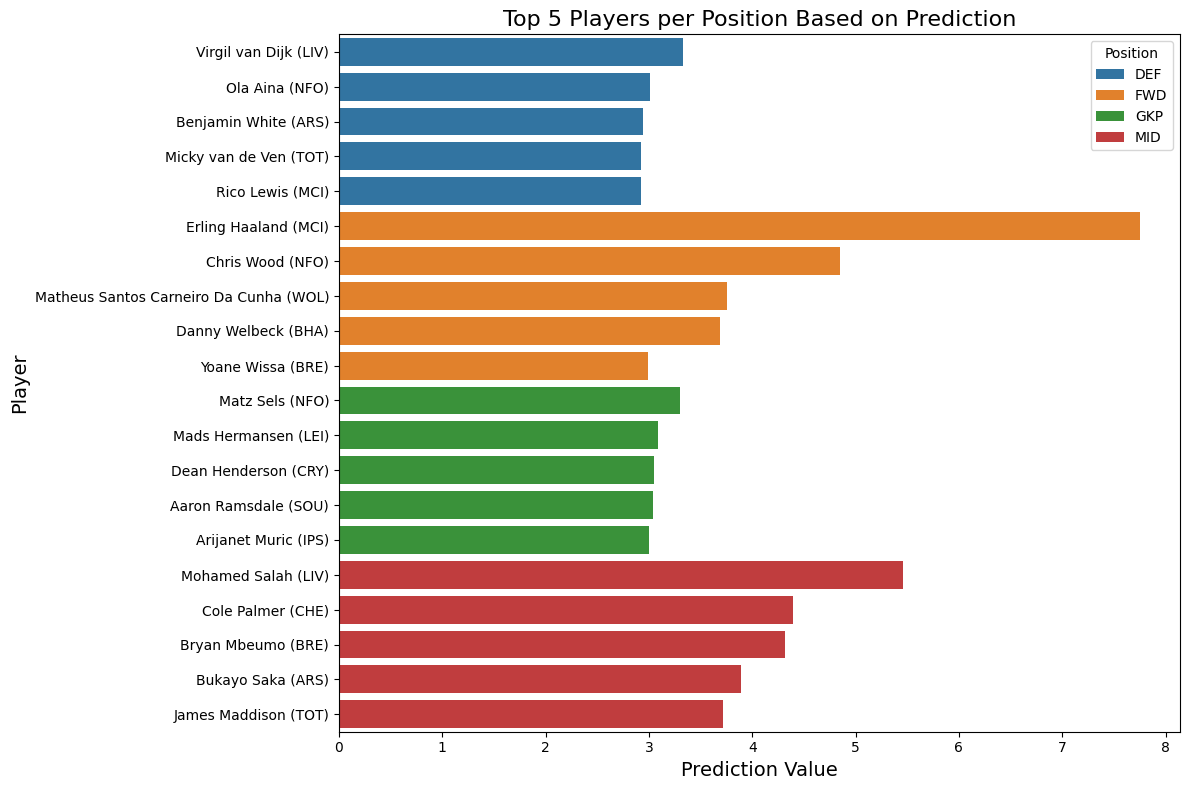

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the dataframe by 'Pos' and 'prediction' to get the top 5 players per position
top_players_per_pos = ssuiio.sort_values(by=['Pos', 'prediction'], ascending=[True, False])

# Group by position and select the top 5 players
top_5_players = top_players_per_pos.groupby('Pos').head(5)

# Create a plot for the top 5 players per position
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_players, x='prediction', y='Player', hue='Pos', dodge=False)

# Title and labels
plt.title('Top 5 Players per Position Based on Prediction', fontsize=16)
plt.xlabel('Prediction Value', fontsize=14)
plt.ylabel('Player', fontsize=14)
plt.legend(title='Position')

# Display the plot
plt.tight_layout()
plt.show()